In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
from util import imshow

%load_ext autoreload
%autoreload 2

np.random.seed(0)
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 1. Least Square Line Fitting

pts shape: (2, 200)


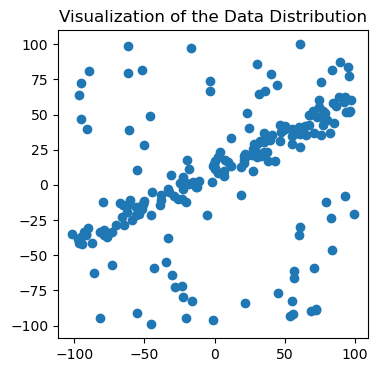

In [2]:
f = scipy.io.loadmat('data/data_f_LSLF.mat')
pts = f['pts']
print("pts shape:", pts.shape)

plt.figure(figsize=(4, 4))
plt.scatter(pts[0], pts[1])
plt.title("Visualization of the Data Distribution")
plt.show()

In [3]:
n = pts.shape[-1]
mu = np.mean(pts, axis=1, keepdims=True)
U = pts - mu
moment = np.dot(U, U.T)

print("second moment:")
print(moment)
print()

e_value, e_vector = np.linalg.eig(moment)
print("eigenvalue of second moment:")
print(e_value)
print()
print("eigenvector of second moment:")
print(e_vector)

second moment:
[[680239.88956594 206911.73976855]
 [206911.73976855 433367.46101812]]

eigenvalue of second moment:
[797737.20772021 315870.14286384]

eigenvector of second moment:
[[ 0.86957598 -0.49379917]
 [ 0.49379917  0.86957598]]


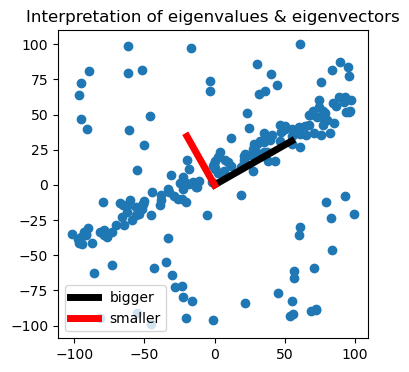

In [4]:
plt.figure(figsize=(4, 4))
plt.scatter(pts[0], pts[1])

scale = np.sqrt(e_value[0] / n)
plt.plot([0, scale*e_vector[0, 0]], [0, scale*e_vector[1, 0]], c='k', linewidth=5, label='bigger')
scale = np.sqrt(e_value[1] / n)
plt.plot([0, scale*e_vector[0, 1]], [0, scale*e_vector[1, 1]], c='r', linewidth=5, label='smaller')

plt.legend()
plt.title("Interpretation of eigenvalues & eigenvectors")
plt.show()

Optimal Line:
-0.4937991695004691*x + 0.8695759772444539*y = 3.310040389017186


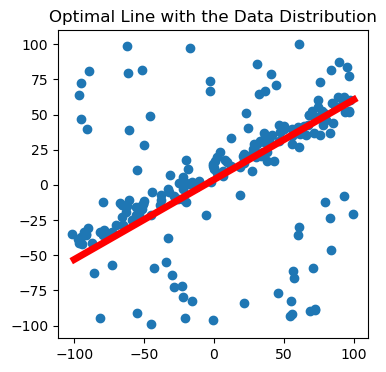

In [5]:
plt.figure(figsize=(4, 4))
plt.scatter(pts[0], pts[1])

a, b = e_vector[:, 1]
d = a * mu[0] + b * mu[1]

print("Optimal Line:")
print(f"{a}*x + {b}*y = {d.item()}")

x = np.linspace(-100, 100, 300)
y = (d - a * x) / b
plt.plot(x, y, linewidth=5, c='r')

plt.title("Optimal Line with the Data Distribution")
plt.show()

## 3. Homography and Image Stitching

### Part 1: Feature Extraction & Matching

In [6]:
def evenly_distributed_SIFT(img, img_size=256, patch_size=128, feature_num=256):
    """
    Get evenly distributed feature points over the given image using SIFT.
    Extract feature points from small patches, merge them, and return them.
    
    Parameters
        img: Square Image to extract feature points.
        img_size: Size of a side of img.
        patch_size: Size of a side of a single patch.
        feature_num: The number of features to extract.
    Returns
        kp_list: List of keypoints.
        des_list: Numpy of descriptors.
    """
    n = img_size // patch_size
    nfeatures = feature_num // (n**2)
    sift = cv2.SIFT_create(nfeatures=nfeatures, contrastThreshold=0)
    
    kp_list = []
    des_list = []
    for i in range(n):
        for j in range(n):
            y, x = i * patch_size, j * patch_size
            img_patch = img[y:y+patch_size, x:x+patch_size]
            kp, des = sift.detectAndCompute(img_patch, None)
            if des is None: continue
            kp, des = kp[:nfeatures], des[:nfeatures]
            
            for keypoint in kp:
                x, y = keypoint.pt
                x, y = x + j * patch_size, y + i * patch_size
                keypoint.pt = (x, y)
            
            kp_list += kp
            des_list.append(des)
            
    des_list = np.concatenate(des_list, axis=0)    
    return kp_list, des_list

def BF_matching(kp1, des1, kp2, des2, match_num):
    """
    Brute Force matching with ratio sorting.
    Do Brute Force matching and sort them by the ratio of the best distance and second-best one.
    
    Parameters
        kp1, kp2: Keypoints from img1 & img2.
        des1, des2: Descriptors from img1 & img2.
        match_num: The number of matches to return.
    Returns
        sorted_match: Best matches. (# sorted_match == match_num)
    """
    bf = cv2.BFMatcher()
    match = bf.knnMatch(des1, des2, k=2)
    ratio = [m.distance / n.distance for m, n in match]
    match = np.array([m for m, n in match])
    idx = np.argsort(ratio)[:match_num]
    sorted_match = match[idx]
    return sorted_match

### Part 2: Direct Linear Transform (DLT)

In [7]:
def DLT(x1, x2):
    """
    Direct Linear Transform using SVD method.
    
    Parameters
        x1, x2: Paired corresponding 2D points.
    Returns
        H: Homography from x1 to x2.
    """
    n = x1.shape[0]
    x1 = np.concatenate([x1, np.ones((n, 1))], axis=1)
    
    A = np.zeros((2*n, 9))
    A[range(0, 2*n, 2), 3:6] = x1
    A[range(1, 2*n, 2), 0:3] = x1
    A[range(0, 2*n, 2), 6:9] = -x2[:, 1:2] * x1
    A[range(1, 2*n, 2), 6:9] = -x2[:, 0:1] * x1

    U, D, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H

### Part 3: RANSAC

In [8]:
def warp(x, H):
    """
    Parameters
        x: Points to warp.
        H: Homography of the warp.
    Returns
        ret: Warped points.
    """
    x = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
    y = np.dot(x, H.T)
    ret = np.divide(y[:, 0:2], y[:, 2:3])
    return ret

class RANSAC:
    """
    RANdom SAmple Consensus for automatic computation of a homography matrix.
    
    Initial parameters
        pts1, pts2: Paired corresponding 2D points.
    """
    def __init__(self, pts1, pts2, **kwargs):
        self.num = pts1.shape[0]
        self.pts1 = pts1
        self.pts2 = pts2
        
        self.t = kwargs['t']
        self.p = kwargs['p']
        self.s = kwargs['s']
        self.max_iter = kwargs['max_iter']
        self.opt_estimation = kwargs['opt_estimation']
    
    def go(self):
        """
        Main runner.
        Do robust estimation. If opt_estimation is true, optimal estimation too.
        
        Returns
            H: Homography matrix using RANSAC.
            error: Mean symmetric transfer error of H.
        """
        H = self.robust_estimation()
        if self.opt_estimation:
            H = self.optimal_estimation(H)
        error = np.mean(self.dist_of_all_match(H))
        print("RANSAC Successfully Terminated!")
        return H, error
            
    def robust_estimation(self):
        """
        Robust Estimation with Adaptive determination of the number of samples for RANSAC.
        """
        opt_H = None
        opt_cnt = 0
        
        N = np.inf
        sample_count = 0
        while sample_count < self.max_iter and sample_count < N:
            H = self.DLT_step()
            dist = self.dist_of_all_match(H)
            in_cnt = np.sum(dist < self.t)
            if in_cnt > opt_cnt:
                opt_H = H
                opt_cnt = in_cnt
                
            N = self.adaptive_determination(in_cnt)
            sample_count += 1
        print(f"> Robust Estimation terminates at iter {sample_count} with {opt_cnt} inliers")
        return opt_H
    
    def optimal_estimation(self, opt_H):
        """
        Optimal Estimation by minimizing cost function with DLT.
        """
        dist = self.dist_of_all_match(opt_H)
        idx = np.where(dist < self.t)[0]
        opt_cnt = idx.shape[0]
        sample_count = 0
        while True:
            H = self.DLT_step(idx)
            dist = self.dist_of_all_match(H)
            idx = np.where(dist < self.t)[0]
            in_cnt = idx.shape[0]
            sample_count += 1
            
            if in_cnt <= opt_cnt: break
            opt_cnt = in_cnt
            opt_H = H
        print(f"> Optimal Estimation terminates at iter {sample_count} with {opt_cnt} inliers")
        return opt_H
        
    def DLT_step(self, idx=None):
        """
        Use DLT function implemented above to guess homography matrix.
        """
        if idx is None:
            idx = np.random.choice(self.num, 4, replace=False)
        x1 = self.pts1[idx]
        x2 = self.pts2[idx]
        H = DLT(x1, x2)
        return H
        
    def dist_of_all_match(self, H):
        """
        Return symmetric transfer error of the given homography H.
        """
        try:
            H_inv = np.linalg.inv(H)
            x1 = self.pts1
            x2 = self.pts2
            y1 = warp(x1, H)
            y2 = warp(x2, H_inv)
            ds = np.sum(np.square(x1 - y2) + np.square(x2 - y1), axis=1)
        except:
            ds = np.ones(self.num) * np.inf
        return ds
    
    def adaptive_determination(self, in_cnt):
        """
        Adaptive determination of the number of samples for RANSAC.
        """
        if in_cnt == 0: return np.inf
        eps = 1 - in_cnt / self.num
        return np.log(1 - self.p) / np.log(1 - (1-eps)**self.s)
    
    
def HbyRANSAC(kp1, kp2, match, **kwargs):
    """
    Get homography using RANSAC class.
    
    Parameters
        kp1, kp2: Keypoints of the images.
        match: Match between kp1, kp2.
    Returns
        Homography matrix by RANSAC using (kp1, kp2, match).
    """
    pts1 = np.array([kp.pt for kp in kp1])
    pts2 = np.array([kp.pt for kp in kp2])
    match = np.array([[mm.queryIdx, mm.trainIdx] for mm in match])
    matched_pts1 = pts1[match[:, 0]]
    matched_pts2 = pts2[match[:, 1]]
    ransac = RANSAC(matched_pts1, matched_pts2, **kwargs)
    return ransac.go()

### Part 4: Warp & Merge

In [9]:
def warp_by_H(from_img, to_img, H, sz):
    """
    Warp (from_img) to (to_img) with homography (H).
    Warp is performed on an image with each side tripled.
    
    Parameters
        from_img, to_img: image to warp from/to.
        H: Homography of the warp.
        sz: Size of a side of img.
    Returns
        to_img: Warped and merged image.
    """
    warp_img = np.zeros((3*sz, 3*sz, 3))
    H_inv = np.linalg.inv(H)
    
    idx = np.arange(3*sz)
    x, y = np.meshgrid(idx, idx)
    x, y = x.reshape(-1), y.reshape(-1)
    res_pts = np.stack([x, y], axis=1)
    pts = warp(res_pts - sz, H_inv)
    xx, yy = pts[:, 0], pts[:, 1]
    
    i, j = np.floor(yy).astype(int), np.floor(xx).astype(int)
    a = np.expand_dims(yy - i, -1)
    b = np.expand_dims(xx - j, -1)
    
    def get_inside(fi, fj):
        ok = (fi >= 0) & (fi < sz) & (fj >= 0) & (fj < sz)
        fi, fj = np.where(ok, fi, 0), np.where(ok, fj, 0)
        return np.where(np.expand_dims(ok, -1), from_img[fi, fj], 0)
    
    warp_img[y, x] += get_inside(i, j) * (1-a)*(1-b)
    warp_img[y, x] += get_inside(i+1, j) * a*(1-b)
    warp_img[y, x] += get_inside(i, j+1) * (1-a)*b
    warp_img[y, x] += get_inside(i+1, j+1) * a*b
    
    warp_img = warp_img.astype(np.uint8)
    to_img = np.where(to_img > warp_img, to_img, warp_img)
    return to_img

def warp_and_merge(img1, img2, img3, H12=None, H32=None, sz=256):
    """
    Merge images using warp_by_H function. If homography is None, warp is not performed.
    
    Paramters
        img1, img2, img3: Images to merge.
        H12, H32: Homography of the warp.
        sz: Size of one sides of the three images which are same.
    Returns
        result_img: Merged image.
    """
    result_img = np.zeros((3*sz, 3*sz, 3), dtype=np.uint8)
    if H12 is not None: result_img = warp_by_H(img1, result_img, H12, sz)
    if H32 is not None: result_img = warp_by_H(img3, result_img, H32, sz)
    result_img[sz:2*sz, sz:2*sz] = img2
    return result_img

### Main

In [10]:
def main(path1, path2, path3, **kwargs):
    img_size = kwargs['img_size']
    patch_size = kwargs['patch_size']
    feature_num = kwargs['feature_num']
    match_num = kwargs['match_num']
    
    # Three Panoramc Pictures
    color_img1 = cv2.imread(path1)
    color_img2 = cv2.imread(path2)
    color_img3 = cv2.imread(path3)
    title = "Three Panoramic Pictures"
    imshow(title, [color_img1, color_img2, color_img3], '3_color')
    
    # Feature Extraction
    img1 = cv2.cvtColor(color_img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(color_img2, cv2.COLOR_BGR2GRAY)
    img3 = cv2.cvtColor(color_img3, cv2.COLOR_BGR2GRAY)
    kp1, des1 = evenly_distributed_SIFT(img1, img_size, patch_size, feature_num)
    kp2, des2 = evenly_distributed_SIFT(img2, img_size, patch_size, feature_num)
    kp3, des3 = evenly_distributed_SIFT(img3, img_size, patch_size, feature_num)
    title = "Feature Extraction"
    sift_img1 = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    sift_img2 = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    sift_img3 = cv2.drawKeypoints(img3, kp3, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    imshow(title, [sift_img1, sift_img2, sift_img3], '3_gray')
    
    # Feature Matching
    match12 = BF_matching(kp1, des1, kp2, des2, match_num)
    match32 = BF_matching(kp3, des3, kp2, des2, match_num)
    title = "Feature Matching btw 1-2 & btw 2-3"
    match_img12 = cv2.drawMatches(img1, kp1, img2, kp2, match12, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    match_img32 = cv2.drawMatches(img3, kp3, img2, kp2, match32, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow(title, [match_img12, match_img32], '2_rec')
    
    # Homography Estimation using RANSAC
    print("H12 by RANSAC Running...")
    H12, error12 = HbyRANSAC(kp1, kp2, match12, **kwargs)
    print("\nHomography Matrix from 1 to 2:")
    print(H12)
    print(f"Mean Symmetric Transfer Error: {error12:.2f} \n")
    
    print("H32 by RANSAC Running...")
    H32, error32 = HbyRANSAC(kp3, kp2, match32, **kwargs)
    print("\nHomography Matrix from 3 to 2:")
    print(H32)
    print(f"Mean Symmetric Transfer Error: {error32:.2f} \n")
    
    # Warping Images & Merge
    merge_img12 = warp_and_merge(color_img1, color_img2, color_img3, H12, None, img_size)
    merge_img32 = warp_and_merge(color_img1, color_img2, color_img3, None, H32, img_size)
    title = "Pairwise matching Results 1-2 & 2-3"
    imshow(title, [merge_img12, merge_img32], '2_squ')
    
    result_img = warp_and_merge(color_img1, color_img2, color_img3, H12, H32, img_size)
    nz_y, nz_x, _ = np.where(result_img > 0)
    result_img = result_img[np.min(nz_y):np.max(nz_y), np.min(nz_x):np.max(nz_x)]
    title = "Final Mosaiced Image"
    imshow(title, [result_img], '1')

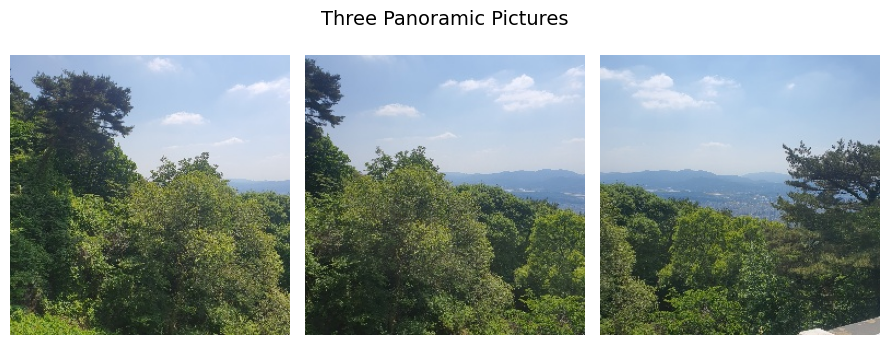

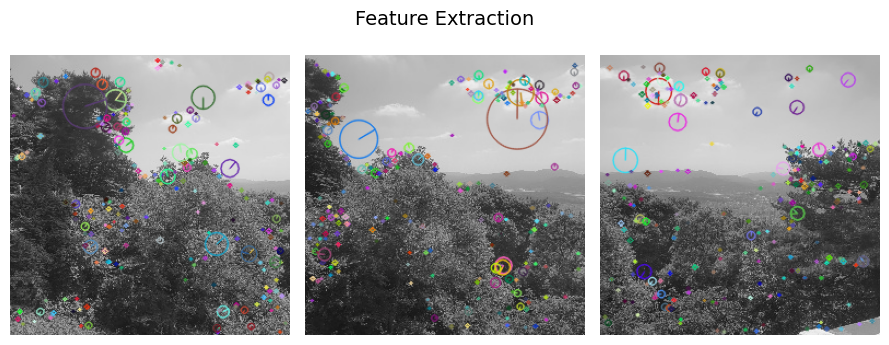

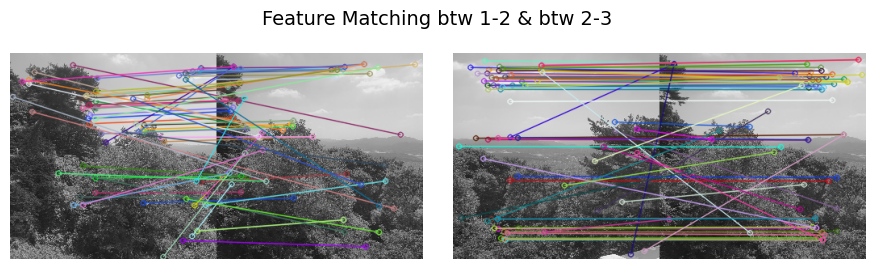

H12 by RANSAC Running...
> Robust Estimation terminates at iter 1265 with 17 inliers
> Optimal Estimation terminates at iter 2 with 19 inliers
RANSAC Successfully Terminated!

Homography Matrix from 1 to 2:
[[-1.15095849e-02 -3.31397700e-04  9.64194688e-01]
 [-1.03713908e-03 -1.06820526e-02  2.64592093e-01]
 [-1.08690984e-05 -1.31689337e-06 -8.47734770e-03]]
Mean Symmetric Transfer Error: 20027.80 

H32 by RANSAC Running...
> Robust Estimation terminates at iter 703 with 24 inliers
> Optimal Estimation terminates at iter 3 with 28 inliers
RANSAC Successfully Terminated!

Homography Matrix from 3 to 2:
[[-3.78193517e-03  1.31315230e-04 -9.96581055e-01]
 [ 1.32608816e-03 -6.01849514e-03 -8.20316254e-02]
 [ 1.10189864e-05 -4.94547116e-08 -6.68666186e-03]]
Mean Symmetric Transfer Error: 34959.65 



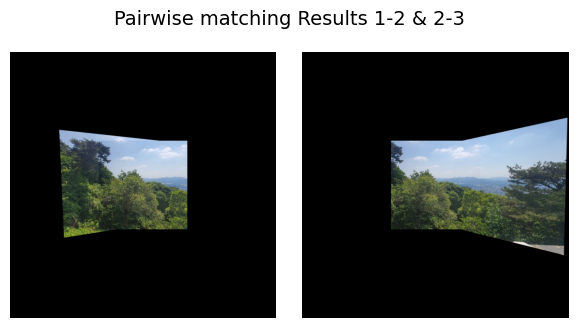

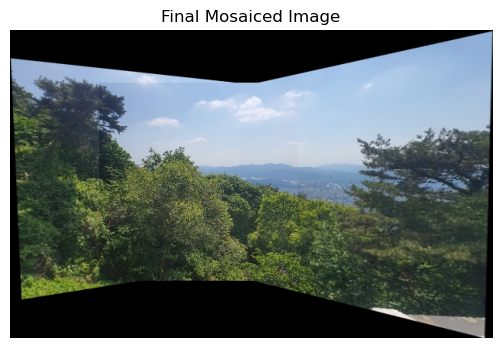

CPU times: user 4.72 s, sys: 263 ms, total: 4.99 s
Wall time: 2.44 s


In [11]:
%%time
kwargs = {
    'img_size': 256,         # Size of a side of a image.
    'patch_size': 128,       # Size of a side of a single patch.
    'feature_num': 256,      # The number of extracted features.
    'match_num': 64,         # The number of matches to use.
    
    'max_iter': 100000,      # Maximum iteration of robust estimation in RANSAC
    'opt_estimation': True,  # Use optimal estimation in RANSAC
    
    ## Parameters for Adaptive Determination
    't': 1.25,
    'p': 0.99,
    's': 4,
}

path1 = 'data/img1_1.jpg'
path2 = 'data/img1_2.jpg'
path3 = 'data/img1_3.jpg'
main(path1, path2, path3, **kwargs)